In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from google.colab import drive
import time

np.random.seed(100)

In [2]:
train_dir = 'E:/dataset/FER2013/train/'
val_dir = 'E:/dataset/FER2013/val/'

BS = 64
PATIENCE =10

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
print(IMAGE_SHAPE)

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

(48, 48, 3)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=False
                                    
                                    )

val_datagen  = ImageDataGenerator(rescale = 1./255
                                   
                                  )

In [4]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)
#test_dir = 'N:/내 드라이브/DataSet/FER2013/test/'
val_dataset = val_datagen.flow_from_directory(directory = val_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
from IPython.display import Image, HTML
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
val_count = count_exp(val_dir, 'val')

HTML(train_count.append(val_count).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,3995,436,4097,7215,4965,4830,3171
val,467,56,496,895,607,653,415


In [7]:
# Data labels

class_labels = val_dataset.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

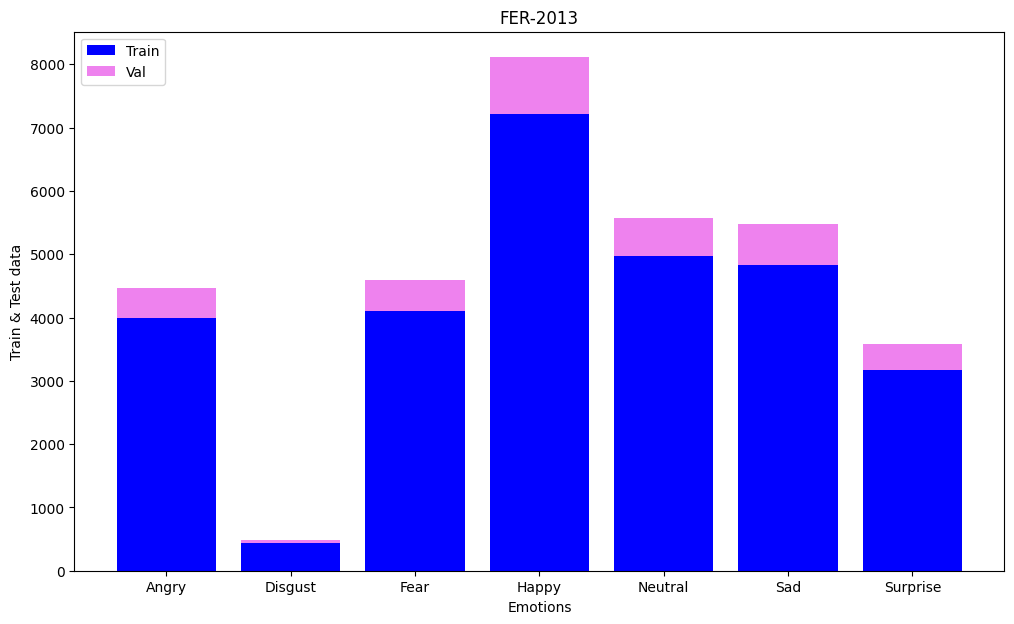

In [8]:
# # lot distribution of train/test dataste per class

x = list(val_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = val_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Val"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

In [9]:
from collections import Counter
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  
class_weights

{0: 1.81, 1: 16.55, 2: 1.76, 3: 1.0, 4: 1.45, 5: 1.49, 6: 2.28}

In [10]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")
base_model.summary()



58889256/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [11]:
for layer in base_model.layers:
    layer.trainable=True

In [16]:
model = models.Sequential()
model.add(base_model)
#model.add(layers.Conv2D(1280, (1, 1), (1, 1), 'same', activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14,847,815
Trainable params: 14,847,815
Non-trainable params: 0
__________________________________________

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [18]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']#, f1_score]
     #metrics=METRICS        
)

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=val_dataset,  
                      callbacks=callbackFunction('3-1_V16_FER2013'),
                      batch_size=BS,  
                      epochs = 30, 
                      verbose=1,
                      class_weight = class_weights
                      )

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 3.2738 - accuracy: 0.2519
Epoch 1: val_accuracy improved from -inf to 0.37058, saving model to Checkpoints\3-1_V16_FER2013.h5
449/449 [==============================] - 22s 41ms/step - loss: 3.2738 - accuracy: 0.2519 - val_loss: 1.6482 - val_accuracy: 0.3706
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 2.9614 - accuracy: 0.3401
Epoch 2: val_accuracy improved from 0.37058 to 0.41042, saving model to Checkpoints\3-1_V16_FER2013.h5
449/449 [==============================] - 21s 47ms/step - loss: 2.9614 - accuracy: 0.3401 - val_loss: 1.5131 - val_accuracy: 0.4104
Epoch 3/30
448/449 [============================>.] - ETA: 0s - loss: 2.7413 - accuracy: 0.3924
Epoch 3: val_accuracy improved from 0.41042 to 0.48398, saving model to Checkpoints\3-1_V16_FER2013.h5
449/449 [==============================] - 20s 44ms/step - loss: 2.7413 - accuracy: 0.3924 - val_loss: 1.3392 - val_accuracy: 0.4840
Epoch 4

Epoch 28/30
449/449 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.6162
Epoch 28: val_accuracy did not improve from 0.60741
449/449 [==============================] - 19s 41ms/step - loss: 1.6641 - accuracy: 0.6162 - val_loss: 1.0830 - val_accuracy: 0.5985
Epoch 29/30
448/449 [============================>.] - ETA: 0s - loss: 1.6366 - accuracy: 0.6226
Epoch 29: val_accuracy improved from 0.60741 to 0.61661, saving model to Checkpoints\3-1_V16_FER2013.h5
449/449 [==============================] - 21s 47ms/step - loss: 1.6371 - accuracy: 0.6225 - val_loss: 1.0231 - val_accuracy: 0.6166
Epoch 30/30
448/449 [============================>.] - ETA: 0s - loss: 1.6214 - accuracy: 0.6276
Epoch 30: val_accuracy improved from 0.61661 to 0.62747, saving model to Checkpoints\3-1_V16_FER2013.h5
449/449 [==============================] - 20s 45ms/step - loss: 1.6208 - accuracy: 0.6279 - val_loss: 1.0215 - val_accuracy: 0.6275


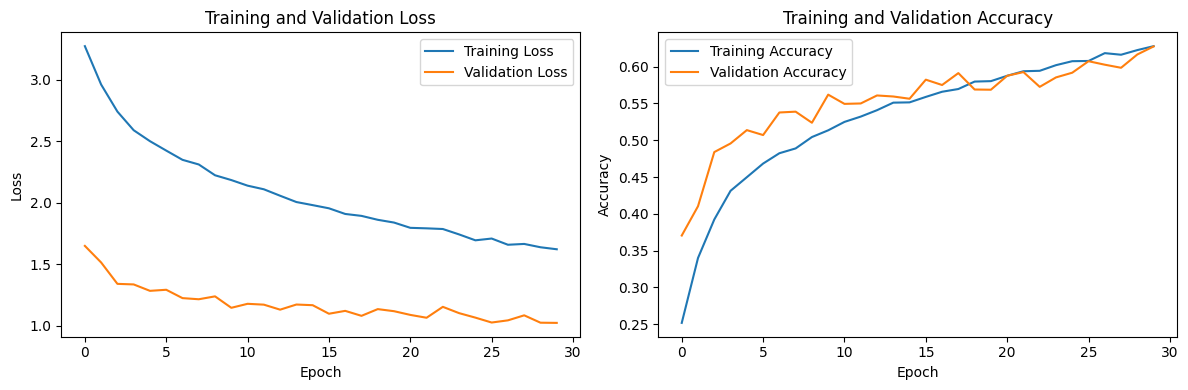

In [20]:
import matplotlib.pyplot as plt

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
model.save('new_3-1_v16_FER2013.h5')

In [22]:
test_dir = 'E:/dataset/Only_Kor_Test/'
test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)
jaffe_dir = 'E:/dataset/jaffedbase/'
jaffe_datagen  = ImageDataGenerator(rescale = 1./255)
jaffe_dataset = test_datagen.flow_from_directory(directory = jaffe_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 758 images belonging to 7 classes.
Found 213 images belonging to 7 classes.


In [23]:
train_evalation = model.evaluate(train_dataset)
val_evalation = model.evaluate(val_dataset)
test_evaluation = model.evaluate(test_dataset)
jaffe_evaluation = model.evaluate(jaffe_dataset)

4/4 [==============================] - 0s 95ms/step - loss: 2.1726 - accuracy: 0.2911


In [26]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evalation],
                           [round(num, 3) for num in test_evaluation],
                           [round(num, 3) for num in jaffe_evaluation],
                          )),
                  columns=['Metric Name', 'Train', 'Validate', 'KFE', 'JAFFE'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate,KFE,JAFFE
0,Loss,0.975,1.022,2.446,2.173
1,Accuracy,0.638,0.627,0.235,0.291
